# 15. Diversity in the Workplace

In [3]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

%matplotlib inline

In [5]:
from platform import python_version
print(python_version())

3.6.10


In [6]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px solid lightgray;
}

In [8]:
pwd

'C:\\Users\\DELL'

In [10]:
cd E:\Jupyter Notebook

[WinError 123] The filename, directory name, or volume label syntax is incorrect: "'E:\\Jupyter Notebook'"
C:\Users\DELL


## Load Dataset

In [7]:
company = pd.read_csv('E:/Collection_DS_takehome_challenges/Data/diversity/company_hierarchy.csv')
company.head()

,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


In [8]:
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  10000 non-null  int64  
 1   boss_id      9999 non-null   float64
 2   dept         10000 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [9]:
employee = pd.read_csv('E:/Collection_DS_takehome_challenges/Data/diversity/employee.csv')
employee.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


In [10]:
employee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   employee_id     10000 non-null  int64  
 1   signing_bonus   10000 non-null  int64  
 2   salary          10000 non-null  float64
 3   degree_level    10000 non-null  object 
 4   sex             10000 non-null  object 
 5   yrs_experience  10000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 468.9+ KB


In [11]:
employee.describe()

,employee_id,signing_bonus,salary,yrs_experience
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,100001.855800,0.301400,189111.800000,3.875200
std,57500.488641,0.458889,88973.796898,3.107409
min,40.000000,0.000000,60000.000000,1.000000
25%,50574.500000,0.000000,110000.000000,2.000000
50%,99244.500000,0.000000,182000.000000,3.000000
75%,149748.500000,1.000000,255000.000000,5.000000
max,199956.000000,1.000000,700000.000000,34.000000


In [12]:
# merge employee and company information
data = pd.merge(left=employee, right=company, on='employee_id')
data.head()

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales
3,29039,0,86000.0,High_School,F,4,88370.0,HR
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales


## Question 1

In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.

* Individual Contributors (IC) - they don't manage anyone
* Middle Managers (MM) - they are the direct bosses of IC
* Directors (D) - they are the direct bosses of MM
* VP - D direct bosses
* Executives (E) - VP direct bosses
* CEO - The direct boss of E.

In [13]:
print(data['dept'].unique())

['engineering' 'sales' 'HR' 'marketing' 'CEO']


In [14]:
levels = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']
data.loc[data['dept'] == 'CEO', 'level'] = 'CEO'
print(data[data['dept'] == 'CEO'])

      employee_id  signing_bonus    salary degree_level sex  yrs_experience  \
6367        61554              1  700000.0          PhD   M               7   

      boss_id dept level  
6367      NaN  CEO   CEO  


In [15]:
for i in range(len(levels) - 1):
    boss_level = levels[i]
    empl_level = levels[i + 1]
    boss_id = data[data['level'] == boss_level]['employee_id']
    data.loc[data['boss_id'].isin(boss_id), 'level'] = empl_level

In [2]:
ESC

NameError: name 'ESC' is not defined

In [16]:
data[['employee_id', 'level']].sample(10)

,employee_id,level
880,20828,MM
5535,13342,IC
5909,17100,IC
7473,155204,IC
6820,194710,IC
2713,148646,MM
7179,99459,IC
2758,195956,IC
5531,21181,IC
8497,184998,MM


In [17]:
# value counts for each group
data['level'].value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

In [18]:
data[['level','employee_id']].groupby('level').count().reset_index().sort_values('employee_id').rename(columns={'employee_id':'Count'})

,level,Count
0,CEO,1
2,E,4
5,VP,35
1,D,160
4,MM,800
3,IC,9000


## Question 2

How many people each employee manages? You should have a table with employee ids and the number of people managed. Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

In [19]:
# find the managed employees for each employee
data['counts'] = 0

for level in ['IC', 'MM', 'D', 'VP', 'E']:
    boss_ids = data[data['level'] == level]['boss_id']
    employee_ids = data[data['level'] == level]['employee_id']
    for b_id, e_id in zip(boss_ids, employee_ids):
        e_counts = int(1 + data.loc[data['employee_id'] == e_id, 'counts'])
        b_counts = int(data.loc[data['employee_id'] == b_id, 'counts'])
        data.loc[data['employee_id'] == b_id, 'counts'] = e_counts + b_counts

In [20]:
data[['employee_id', 'level', 'counts']].head(20)

,employee_id,level,counts
0,138719,IC,0
1,3192,IC,0
2,114657,IC,0
3,29039,IC,0
4,118607,IC,0
5,91334,IC,0
6,101901,MM,6
7,171111,IC,0
8,23443,IC,0
9,24195,IC,0


## Question 3

Build a model to predict the salary of each employee.

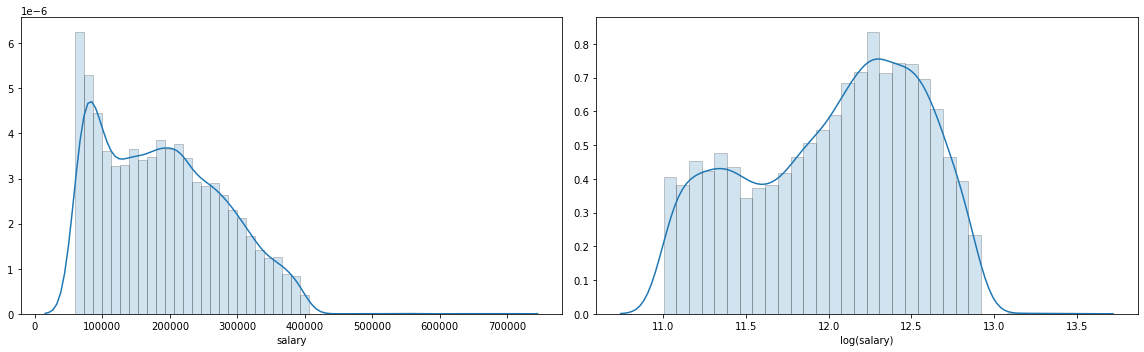

In [21]:
# Distribution of salary
warnings.filterwarnings('ignore')
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.distplot(data['salary'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(data['salary']), ax=ax[1], hist_kws=hist_kws)
ax[1].set_xlabel('log(salary)')
plt.tight_layout()
plt.show()

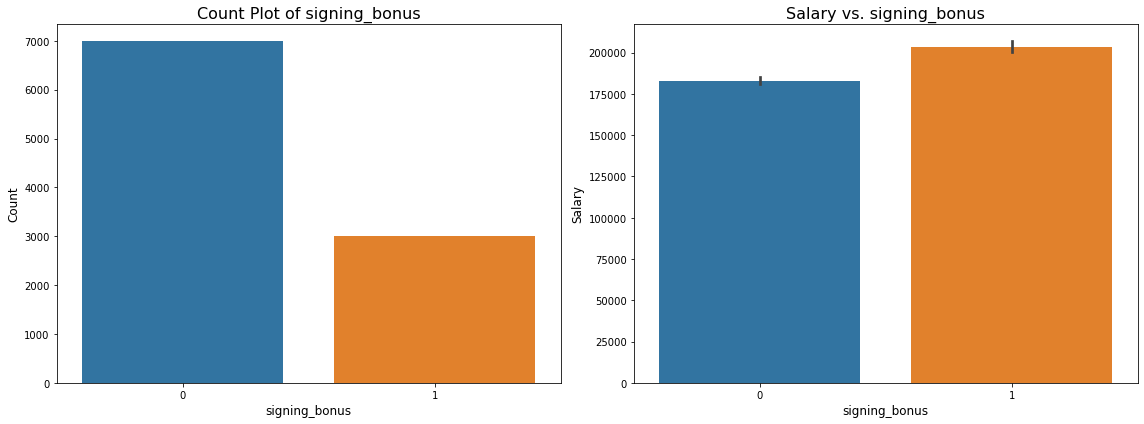

In [22]:
# visualization of 'signing_bonus'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='signing_bonus', data=data, ax=ax[0])
ax[0].set_xlabel('signing_bonus', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of signing_bonus', fontsize=16)

sns.barplot(x='signing_bonus', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('signing_bonus', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. signing_bonus', fontsize=16)
plt.tight_layout()
plt.show()

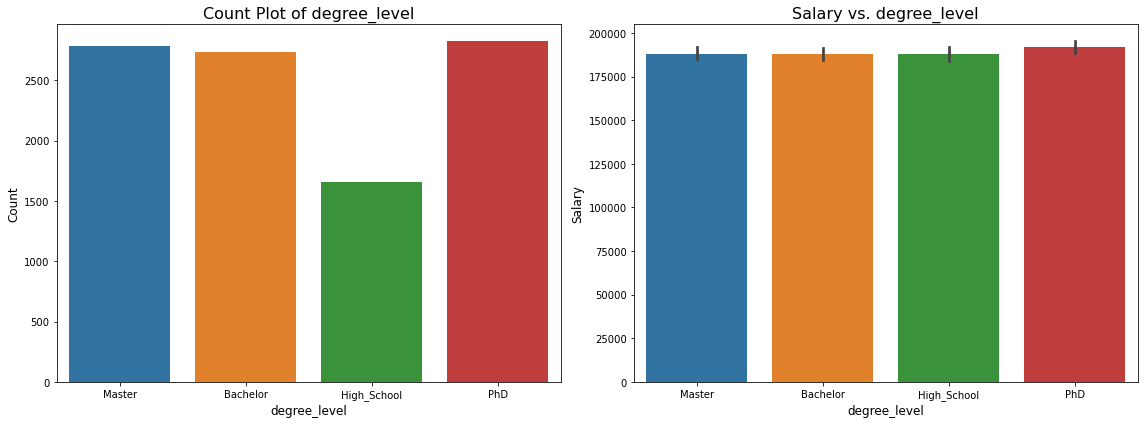

In [26]:

# visualization of 'degree_level'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='degree_level', data=data, ax=ax[0])
ax[0].set_xlabel('degree_level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of degree_level', fontsize=16)

sns.barplot(x='degree_level', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('degree_level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. degree_level', fontsize=16)
plt.tight_layout()
plt.show()

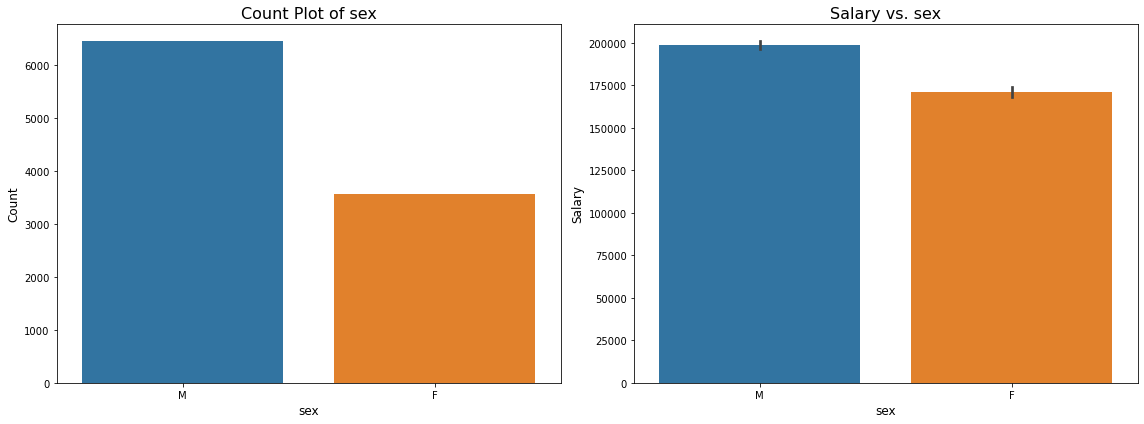

In [27]:
# visualization of 'sex'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='sex', data=data, ax=ax[0])
ax[0].set_xlabel('sex', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of sex', fontsize=16)

sns.barplot(x='sex', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('sex', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. sex', fontsize=16)
plt.tight_layout()
plt.show()

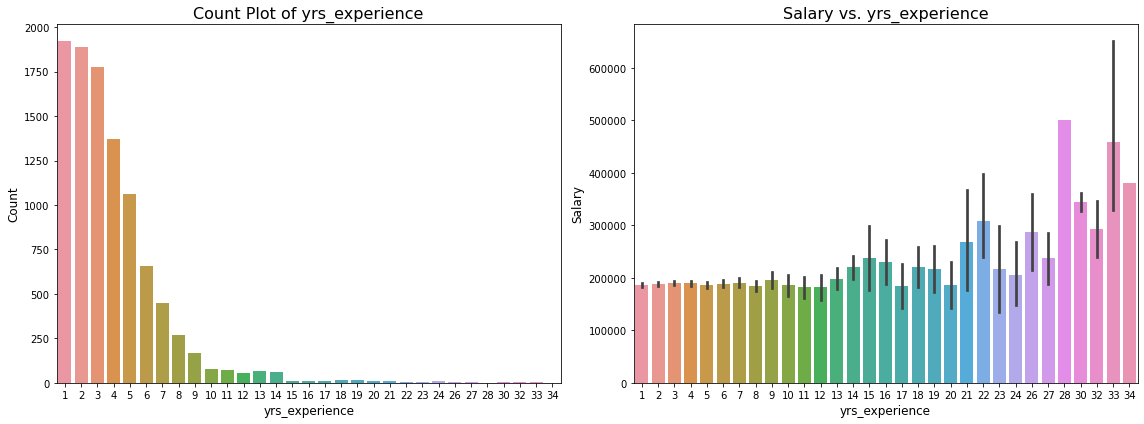

In [28]:
# visualization of 'yrs_experience'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='yrs_experience', data=data, ax=ax[0])
ax[0].set_xlabel('yrs_experience', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of yrs_experience', fontsize=16)

sns.barplot(x='yrs_experience', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('yrs_experience', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. yrs_experience', fontsize=16)
plt.tight_layout()
plt.show()

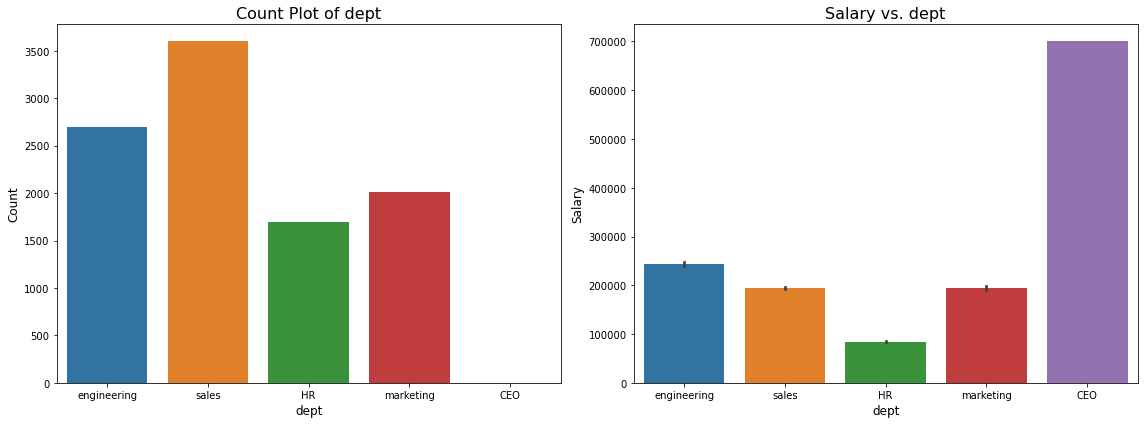

In [29]:
# visualization of 'dept'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='dept', data=data, ax=ax[0])
ax[0].set_xlabel('dept', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of dept', fontsize=16)

sns.barplot(x='dept', y='salary', data=data, ax=ax[1])
ax[1].set_xlabel('dept', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. dept', fontsize=16)
plt.tight_layout()
plt.show()

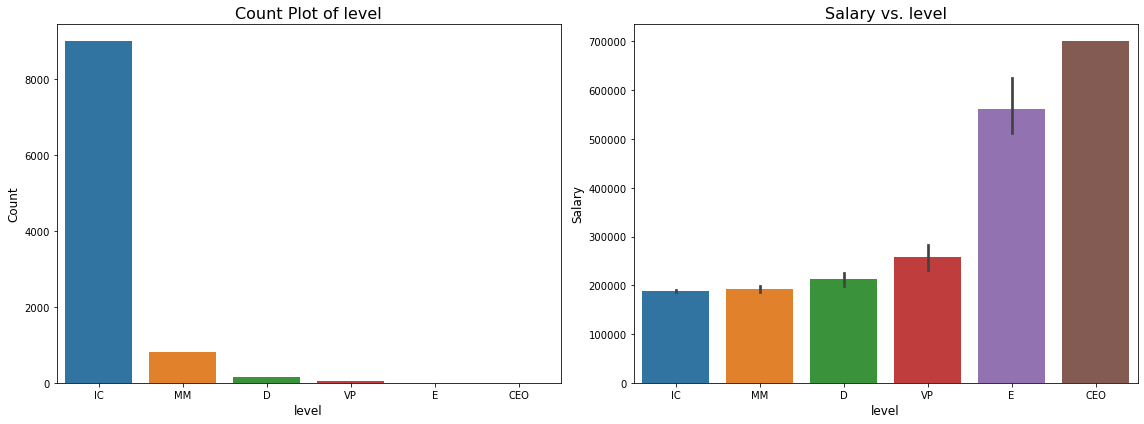

In [30]:
# visualization of 'level'
orders = ['IC', 'MM', 'D', 'VP', 'E', 'CEO']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.countplot(x='level', data=data, ax=ax[0], order=orders)
ax[0].set_xlabel('level', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of level', fontsize=16)

sns.barplot(x='level', y='salary', data=data, ax=ax[1], order=orders)
ax[1].set_xlabel('level', fontsize=12)
ax[1].set_ylabel('Salary', fontsize=12)
ax[1].set_title('Salary vs. level', fontsize=16)
plt.tight_layout()
plt.show()

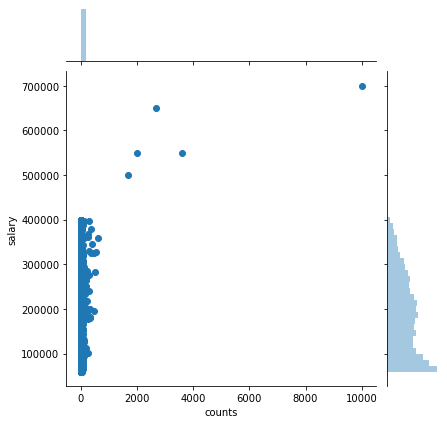

In [31]:
sns.jointplot(x='counts', y='salary', data=data, kind='scatter', size=6)
plt.show()

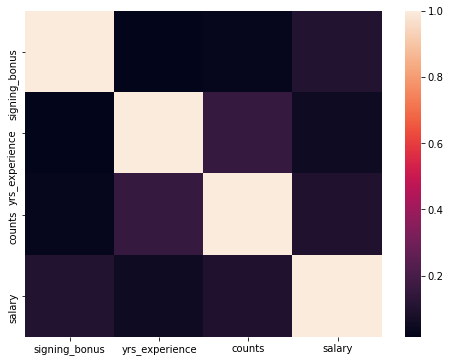

In [37]:
fig, ax = plt.subplots(figsize=(8, 6))
subset = data[['signing_bonus', 'yrs_experience', 'counts', 'salary']]
sns.heatmap(subset.corr(), ax=ax)
plt.show()

### Build Machine Learning Models with LightGBM

In [38]:
# Drop CEO department
data = data[data['dept'] != 'CEO']

# drop useless features
data = data.drop(labels=['employee_id', 'boss_id', 'level', 'counts'], axis=1)

data.head()

,signing_bonus,salary,degree_level,sex,yrs_experience,dept
0,0,273000.0,Master,M,2,engineering
1,0,301000.0,Bachelor,F,1,sales
2,0,261000.0,Master,F,2,sales
3,0,86000.0,High_School,F,4,HR
4,0,126000.0,Bachelor,F,3,sales


In [39]:
# encoding categorical data
data['sex'] = (data['sex'] == 'M').astype(int)

degree_encoder = LabelEncoder()
data['degree_level'] = degree_encoder.fit_transform(data['degree_level'])

dept_encoder = LabelEncoder()
data['dept'] = dept_encoder.fit_transform(data['dept'])

In [40]:
data.head()

,signing_bonus,salary,degree_level,sex,yrs_experience,dept
0,0,273000.0,2,1,2,1
1,0,301000.0,0,0,1,3
2,0,261000.0,2,0,2,3
3,0,86000.0,1,0,4,0
4,0,126000.0,0,0,3,3


In [41]:
# define categorical features
categorical_feature = ['signing_bonus', 'degree_level', 'sex', 'dept']
data[categorical_feature] = data[categorical_feature].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   signing_bonus   9999 non-null   category
 1   salary          9999 non-null   float64 
 2   degree_level    9999 non-null   category
 3   sex             9999 non-null   category
 4   yrs_experience  9999 non-null   int64   
 5   dept            9999 non-null   category
dtypes: category(4), float64(1), int64(1)
memory usage: 274.0 KB


In [47]:
# split into training and test data set
X = data.drop('salary', axis=1)
y = data['salary']

X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.25, random_state=42)

# transform into log scale
y_train = np.log(y_train)
y_test = np.log(y_test)

In [48]:
# create LightGBM dataset
d_train = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False, 
                      categorical_feature=categorical_feature)

In [49]:
# Cross validation
params = {'learning_rate': 0.01, 
          'boosting_type': 'gbdt', 
          'objective': 'regression', 
          'metric': 'rmse', 
          'sub_feature':0.5, 
          'num_leaves': 31, 
          'min_data': 50, 
          'max_depth': 30}

history = lgb.cv(params, train_set=d_train, num_boost_round=1000, nfold=5, 
                 early_stopping_rounds=20, seed=42, stratified=False)

best_round = len(history['rmse-mean'])
print('Best rounds:\t', best_round)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 5996, number of used features: 5
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

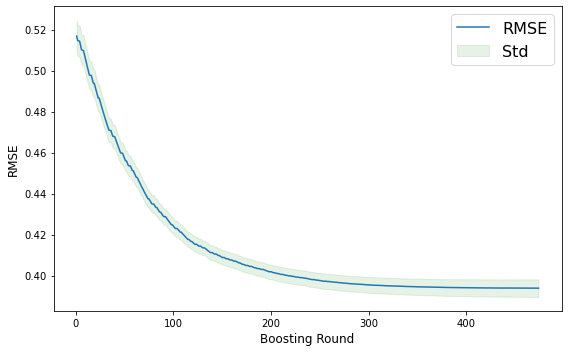

In [50]:
# visualization
rmse = np.array(history['rmse-mean'])
std = np.array(history['rmse-stdv'])
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1, best_round + 1), rmse, label='RMSE')
ax.fill_between(range(1, best_round + 1), rmse + std, rmse - std, 
                alpha=0.1, color='g', label='Std')
ax.set_xlabel('Boosting Round', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

In [51]:
# re-train the model and make predictions
clf = lgb.train(params, train_set=d_train, num_boost_round=best_round)
pred = clf.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 7499, number of used features: 5
[LightGBM] [Info] Start training from score 12.020859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [55]:
from sklearn.metrics import mean_squared_error,r2_score
print('Test RMSE:\t', np.sqrt(mean_squared_error(y_test, pred)))
print('Test R2:\t', r2_score(y_test, pred))

Test RMSE:	 0.39080803975717354
Test R2:	 0.4020007295623995


## Question 4

Describe the main factors impacting employee salaries. Do you think the company has been treating its employees fairly? Do you see any bias? What are the next steps you would suggest to the Head of HR?

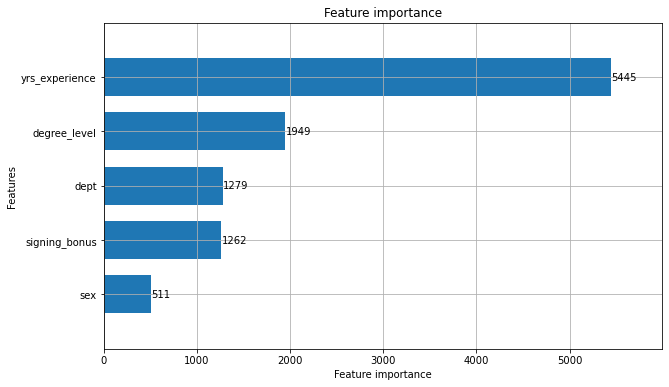

In [56]:
# feature importance
features = clf.feature_name()
importance = clf.feature_importance()

fig, ax = plt.subplots(figsize=(10, 6))
lgb.plot_importance(clf, ax=ax, height=0.7)
plt.show()


From above figure, we can see that years experience is the most influencial factor for employee's salary.

For bias, you can refer to Link